In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
pd.options.mode.chained_assignment = None
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import Utils.iris_utils
import Utils.Gridding
from Utils.nc_processing import *
from Utils.analysis import * 
#from Utils.plotting import *
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
import scipy
#sns.set()

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_hadcrut(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/iris/experimental/regrid.py:55: IrisDeprecation: The 'iris.experimental.regrid' package is deprecated since version 3.2, and will be removed in a future release.  The PointInCell class has now moved into iris.analysis.  All its other content will be withdrawn.  If you still use any of this, please contact the Iris Developers to discuss how to replace it or to retain it (reverse the deprecation).
  warn_deprecated(wmsg)


In [2]:
### set up and read in temp data

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=10
temp_thresh = 1.5
#temp_thresh = 2

in_folder_tas = 'int_outputs/temperature_v2/'
#exp='ssp370'
exp='ssp245'
#exp='ssp126'
tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]
#tas_df.set_index('year',inplace=True)
print(tas_df['Model'].unique())

## observations
#Hadcrut_file = 'Inputs/HadCRUT5/Downloaded_29_12_22/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'
Hadcrut_file = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'
Hadcrut_df = preprocess_hadcrut(pd.read_csv(Hadcrut_file), window=window)



['TaiESM1' 'AWI-CM-1-1-MR' 'MCM-UA-1-0' 'CIESM' 'SAM0-UNICON' 'NESM3'
 'GFDL-ESM4' 'GFDL-CM4' 'UKESM1-0-LL' 'KACE-1-0-G' 'NorESM2-MM'
 'NorESM2-LM' 'NorCPM1' 'CESM2-WACCM-FV2' 'CESM2-WACCM' 'CESM2-FV2'
 'CESM2' 'GISS-E2-2-H' 'GISS-E2-1-H' 'GISS-E2-1-G-CC' 'GISS-E2-1-G'
 'MRI-ESM2-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'UKESM1-1-LL'
 'HadGEM3-GC31-MM' 'HadGEM3-GC31-LL' 'MIROC6' 'MIROC-ES2L' 'MIROC-ES2H'
 'KIOST-ESM' 'IPSL-CM6A-LR-INCA' 'IPSL-CM6A-LR' 'IPSL-CM5A2-INCA'
 'INM-CM5-0' 'INM-CM4-8' 'MPI-ESM-1-2-HAM' 'FIO-ESM-2-0'
 'EC-Earth3-Veg-LR' 'BCC-CSM2-MR' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'FGOALS-f3-L'
 'FGOALS-g3' 'IITM-ESM' 'CanESM5' 'CanESM5-CanOE' 'CMCC-CM2-SR5'
 'CMCC-ESM2' 'CNRM-CM6-1' 'CNRM-CM6-1-HR' 'CNRM-ESM2-1' 'ACCESS-ESM1-5'
 'ACCESS-CM2' 'E3SM-1-1' 'EC-Earth3' 'EC-Earth3-CC' 'EC-Earth3-Veg']


In [3]:
### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available

tas_df = tas_df.groupby(['year', 'Experiment', 'Model']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900])
tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
models

/tmp/ipykernel_717/3777482543.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]


array(['AWI-CM-1-1-MR', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4',
       'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1',
       'UKESM1-0-LL'], dtype=object)

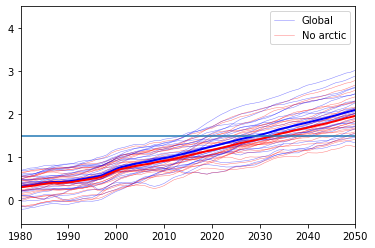

In [4]:
### initial basic plot, no correction to force realistic present temps

for model in models:
    df = tas_df[tas_df['Model']==model]
    plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=0.5, linewidth=0.5, label='Global')
    plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=0.5, linewidth=0.5, label='No arctic')

df = tas_df.groupby(['year']).mean().reset_index() 
plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=1, linewidth=2, label='Global')
plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=1, linewidth=2, label='No arctic')

legend_without_duplicate_labels(plt.gca())
plt.xlim(1980,2050)
plt.axhline(1.5)
plt.savefig('Figures/tas_anom_global_and_no_arctic.png', dpi=300)


In [5]:


#df= tas_df[tas_df['Experiment'] == exp]
df = tas_df.drop(columns=['Experiment'])
models = df['Model'].unique()
Model = []
No_arctic = []
World = []

for m in models:
    m_df = df[df['Model']==m]
    no_arctic_crossing_year = np.interp(temp_thresh, m_df['no_arctic_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    world_crossing_year = np.interp(temp_thresh, m_df['world_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    Model.append(m)
    No_arctic.append(np.round(no_arctic_crossing_year,3))
    World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
print('mean gap for crossing {}C: '.format(temp_thresh) + str(np.round(out_df['gap'].mean(), 2)))
#out_df.to_csv('Outputs/crossing_years.csv')
out_df

mean gap for crossing 1.5C: 3.57


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2024.194,2019.835,4.359
1,CESM2,2036.599,2031.641,4.958
2,CESM2-WACCM,2029.769,2027.225,2.544
3,CIESM,2014.664,2013.661,1.003
4,EC-Earth3-Veg-LR,2035.941,2026.083,9.858
5,FIO-ESM-2-0,2020.407,2017.602,2.805
6,GFDL-CM4,2036.399,2031.566,4.833
7,GFDL-ESM4,2050.706,2048.423,2.283
8,GISS-E2-1-G,2059.689,2055.529,4.160
9,HadGEM3-GC31-LL,2024.488,2022.222,2.266


In [6]:
df.columns

Index(['year', 'Model', 'no_arctic_tas', 'world_tas', 'base_t_bnds',
       'no_arctic_base_tas', 'world_base_tas', 'no_arctic_tas_anom',
       'world_tas_anom'],
      dtype='object')

observation year: 2018
HadCRUT temp in obs_year:1.1396610170295498
HadCRUT temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278


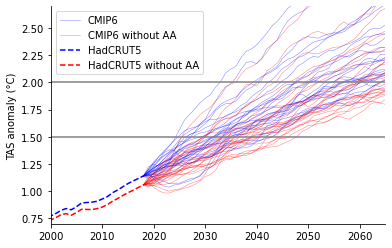

In [7]:
""" repeat, this time scaling temps to current observed warming """

global_warming_obs = float(Hadcrut_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Hadcrut_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Hadcrut_df.dropna().tail(1)['year'])

Model = []
No_arctic = []
World = []
df = tas_df
M_df = pd.DataFrame(columns=df.columns)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for m in models:
        m_df = df[df['Model']==m]
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()
        
        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        
        m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio_w).rolling(window, center=True).mean()
        m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio_na).rolling(window, center=True).mean()
        
        m_df_plot = m_df[m_df['year'] >= obs_year]
        
        plt.plot(m_df_plot['year'], m_df_plot['adjusted_world_tas_anom'],
                 c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
        plt.plot(m_df_plot['year'], m_df_plot['adjusted_no_arctic_tas_anom'], 
                 c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')

        M_df = M_df.append(m_df, ignore_index = True)
        #also calc crossings again
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']

#mm_mean_df = out_df.groupby()

## add observations:
plt.plot(Hadcrut_df['year'], Hadcrut_df['world_tas'], c='blue', 
         linestyle='--', label='HadCRUT5')
plt.plot(Hadcrut_df['year'], Hadcrut_df['no_arctic_tas'], c='red', 
         linestyle='--', label='HadCRUT5 without AA')

legend_without_duplicate_labels(plt.gca())
plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('Figures/tas_projections.png', dpi=300)

print('observation year: ' + str(obs_year))
print('HadCRUT temp in obs_year:' + str(global_warming_obs))
print('HadCRUT temp without AA in obs_year:' + str(no_arctic_warming_obs))
print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))

In [8]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Hadcrut_df.to_csv('Outputs/Processed_Hadcrut_{r}yr_rolling.csv'.format(r=window))

In [9]:
mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
out_df

mean gap for crossing 1.5C: 4.64 +- 0.52 years


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2040.432,2035.125,5.307
1,CESM2,2030.084,2026.626,3.458
2,CESM2-WACCM,2035.742,2032.067,3.675
3,CIESM,2039.372,2031.492,7.880
4,EC-Earth3-Veg-LR,2044.850,2043.028,1.822
5,FIO-ESM-2-0,2037.829,2033.193,4.636
6,GFDL-CM4,2032.606,2026.246,6.360
7,GFDL-ESM4,2047.626,2038.944,8.682
8,GISS-E2-1-G,2030.006,2027.181,2.825
9,HadGEM3-GC31-LL,2029.540,2024.740,4.800


In [10]:
len(out_df)

26

In [11]:
### now generate box plot by model (vertical), with multiple ensemble members for error bars

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()

#tas_df = tas_df[tas_df['Experiment'] != 'historical']
#tas_df = tas_df.drop(columns=['Experiment'])

#also calc crossings
Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']=='ssp245']['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        except:
            print('error on: ' + m + e)
            
        me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
        me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 3
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))



/tmp/ipykernel_717/3777482543.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]


error on: E3SM-1-1r1i1p1f1


In [12]:
out_df_ME_all

,Model,Ensemble_member,No_arctic_crossing_year,World_crossing_year,gap
0,ACCESS-CM2,r1i1p1f1,2028.440,2025.016,3.424
1,ACCESS-CM2,r2i1p1f1,2030.521,2027.185,3.336
2,ACCESS-ESM1-5,r1i1p1f1,2028.441,2026.797,1.644
3,ACCESS-ESM1-5,r2i1p1f1,2035.623,2033.354,2.269
4,ACCESS-ESM1-5,r3i1p1f1,2032.390,2026.540,5.850
...,...,...,...,...,...
177,UKESM1-0-LL,r2i1p1f2,2026.952,2023.848,3.104
178,UKESM1-0-LL,r3i1p1f2,2031.084,2027.386,3.698
179,UKESM1-0-LL,r4i1p1f2,2026.414,2023.725,2.689
180,UKESM1-0-LL,r8i1p1f2,2028.827,2025.421,3.406


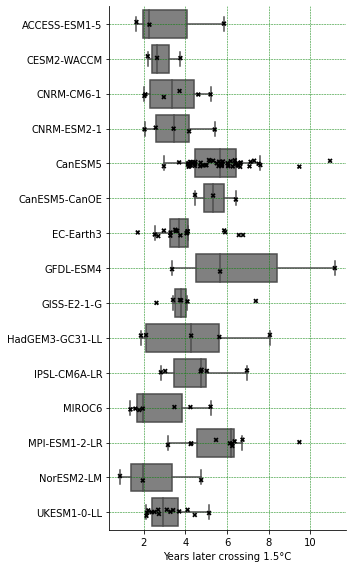

In [13]:
## plot
sns.boxplot(data=out_df_ME, x='gap', y='Model', color='gray', showfliers = False)
sns.stripplot(data=out_df_ME, x='gap', y='Model', color='black', marker='X')
plt.ylabel('')
plt.xlabel('Years later crossing {}°C'.format(temp_thresh))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

fig = plt.gcf()
fig.set_size_inches(5, 8)
plt.tight_layout()
plt.savefig('Figures/crossing_years.png', dpi=300)

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(out_df_ME)


               Model Ensemble_member  No_arctic_crossing_year  \
2      ACCESS-ESM1-5        r1i1p1f1                 2028.441   
3      ACCESS-ESM1-5        r2i1p1f1                 2035.623   
4      ACCESS-ESM1-5        r3i1p1f1                 2032.390   
9        CESM2-WACCM        r1i1p1f1                 2034.016   
10       CESM2-WACCM        r2i1p1f1                 2039.471   
11       CESM2-WACCM        r3i1p1f1                 2037.031   
15        CNRM-CM6-1       r10i1p1f2                      NaN   
16        CNRM-CM6-1        r1i1p1f2                 2033.343   
17        CNRM-CM6-1        r2i1p1f2                 2029.131   
18        CNRM-CM6-1        r3i1p1f2                 2034.945   
19        CNRM-CM6-1        r4i1p1f2                 2026.995   
20        CNRM-CM6-1        r5i1p1f2                 2034.238   
21        CNRM-CM6-1        r6i1p1f2                 2032.284   
22        CNRM-CM6-1        r7i1p1f2                      NaN   
23        CNRM-CM6-1     